# Importing necessary modules

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta

from textblob import TextBlob
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

from sklearn.model_selection import train_test_split
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D

C:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Scraping news about top S&P 500 companies from CNBC website

URL = 'https://www.cnbc.com/sp-500/'
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find_all("div", {"class": "stories-lineup bigHeader"})

# Only one class on the page so results[0]
results = results[0]

I skimmed the website and discovered there are several advertisements which are irrelevant, so I needed to put functions to avoid them

In [3]:
# Functions to skip ads
def ad_headline(var):
    try:
        return var.find("div", {"class": "headline"}).get_text().strip()
    except AttributeError:
        pass

def ad_time(var):
    try:
        return var.find("time").get_text()
    except AttributeError:
        pass
    
def ad_description(var):
    try:
        return var.find("p", {"class": "desc"}).get_text()
    except AttributeError:
        pass

Now, actual scrape loop can run by scraping only news data and skipping advertisements

In [4]:
# Scraping headlines, date, and description
scraped = []
for i in range(1, 350): # After adjusting various ranges, 350 seemed to be working fine
    URL_new = URL + "?page=" + str(i)
    page = requests.get(URL_new)
    soup = BeautifulSoup(page.content, 'html.parser')
    results = soup.find_all("div", {"class": "stories-lineup bigHeader"})
    results = results[0]
    news = results.find_all("li")
    for n in news:
        data = []
        data.append(ad_headline(n))
        data.append(ad_time(n))
        data.append(ad_description(n))
        scraped.append(data)
        
# Creating dataframe
df = pd.DataFrame.from_records(scraped)
df.columns = ["Headlines", "Time", "Description"]

# Creating CSV
df.to_csv("scraped_news_dataset.csv", index = False)

In [5]:
# Viewing dataframe to get an idea of scraped data
df

,Headlines,Time,Description
0,Cramer's Lightning Round: 'Too much hype' for ...,20 Hours Ago,"""Mad Money"" host Jim Cramer rings the lightnin..."
1,Cramer's Lightning Round: Energy Transfer is a...,"7:21 PM ET Mon, 13 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
2,None,None,None
3,Cramer's Lightning Round: Uber is a buy,"7:09 PM ET Fri, 10 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
4,Cramer's Lightning Round: Buy AutoZone,"7:23 PM ET Thu, 9 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
...,...,...,...
7673,Cramer: It's too crazy to buy stocks now,"6:28 PM ET Thu, 3 Dec 2015",Jim Cramer goes through the list of unexpected...
7674,Lightning Round: This is too good to trade around,"7:28 PM ET Wed, 2 Dec 2015",Jim Cramer rattles off his take on caller favo...
7675,Cramer Remix: These stocks are punished enough,"8:21 PM ET Wed, 2 Dec 2015",“Mad Money” host Jim Cramer is recommending th...
7676,Cramer: Saudi Arabia could crush oil next year,"11:21 AM ET Thu, 3 Dec 2015",Jim Cramer makes the case as to why Saudi Arab...


Now we can see that the scraped data needs cleaning because there are empty rows, time and date format is not appropriate for our requirement etc.

# Cleaning data

In [6]:
new_df = pd.read_csv("scraped_news_dataset.csv")

# Removing empty rows
new_df = new_df.dropna()

# Removing duplicates
new_df = new_df.drop_duplicates(subset=['Headlines', 'Description'], keep='first')

# Rearranging data
new_df.reset_index(drop=True, inplace=True)
new_df

,Headlines,Time,Description
0,Cramer's Lightning Round: 'Too much hype' for ...,20 Hours Ago,"""Mad Money"" host Jim Cramer rings the lightnin..."
1,Cramer's Lightning Round: Energy Transfer is a...,"7:21 PM ET Mon, 13 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
2,Cramer's Lightning Round: Uber is a buy,"7:09 PM ET Fri, 10 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
3,Cramer's Lightning Round: Buy AutoZone,"7:23 PM ET Thu, 9 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
4,Cramer's Lightning Round: 'Do not touch' UiPath,"7:18 PM ET Wed, 8 Nov 2023","""Mad Money"" host Jim Cramer rings the lightnin..."
...,...,...,...
6917,Cramer: It's too crazy to buy stocks now,"6:28 PM ET Thu, 3 Dec 2015",Jim Cramer goes through the list of unexpected...
6918,Lightning Round: This is too good to trade around,"7:28 PM ET Wed, 2 Dec 2015",Jim Cramer rattles off his take on caller favo...
6919,Cramer Remix: These stocks are punished enough,"8:21 PM ET Wed, 2 Dec 2015",“Mad Money” host Jim Cramer is recommending th...
6920,Cramer: Saudi Arabia could crush oil next year,"11:21 AM ET Thu, 3 Dec 2015",Jim Cramer makes the case as to why Saudi Arab...


The date and time format needs to be adjusted such that we have numerical data to process

In [7]:
# Function to handle cases for headlines published a few hours ago without date format (eg. 2 hours ago)
def parse_time_ago(dt):
    match = re.match(r'(\d+) (\w+) Ago', dt)
    if match:
        num, unit = match.groups()
        num = int(num)
        if unit.lower() in ['hour', 'hours']:
            return datetime.now() - timedelta(hours=num)
        elif unit.lower() in ['day', 'days']:
            return datetime.now() - timedelta(days=num)
    return None

# Function to transform Time column
def date_time(dt):
    parsed_time_ago = parse_time_ago(dt)
    if parsed_time_ago:
        return parsed_time_ago.strftime("%m-%d-%Y"), parsed_time_ago.strftime("%H:%M:%S")
    
     # On checking dataset, January is Jan, February is Feb but March is March. 
    # 5 month names were long and rest were 3 letters, so changing these 5 also
    dt = dt.replace("March", "Mar").replace("April", "Apr").replace("June", "Jun").replace("July", "Jul").replace("Sept", "Sep")
    
    # Cleaning spacing issues
    if dt[0].isspace():
        dt = dt.replace(" ", "0", 1)
    dt = dt.replace(",  ", ", 0", 1)
    return datetime.strptime(dt, new_format).strftime("%m-%d-%Y"), datetime.strptime(dt, new_format).strftime("%H:%M:%S")

new_format = '%I:%M %p ET %a, %d %b %Y'
d = []
t = []

for n in new_df.iloc[:, 1].values:
    n_date, n_time = date_time(n)
    d.append(n_date)
    t.append(n_time)

# Applying to new dataframe
new_df['Date'] = d
new_df["Date"] = new_df["Date"].astype("datetime64")
new_df['Time'] = t
new_df = new_df[["Date", "Time", "Headlines", "Description"]]
new_df


,Date,Time,Headlines,Description
0,2023-11-15,00:51:18,Cramer's Lightning Round: 'Too much hype' for ...,"""Mad Money"" host Jim Cramer rings the lightnin..."
1,2023-11-13,19:21:00,Cramer's Lightning Round: Energy Transfer is a...,"""Mad Money"" host Jim Cramer rings the lightnin..."
2,2023-11-10,19:09:00,Cramer's Lightning Round: Uber is a buy,"""Mad Money"" host Jim Cramer rings the lightnin..."
3,2023-11-09,19:23:00,Cramer's Lightning Round: Buy AutoZone,"""Mad Money"" host Jim Cramer rings the lightnin..."
4,2023-11-08,19:18:00,Cramer's Lightning Round: 'Do not touch' UiPath,"""Mad Money"" host Jim Cramer rings the lightnin..."
...,...,...,...,...
6917,2015-12-03,18:28:00,Cramer: It's too crazy to buy stocks now,Jim Cramer goes through the list of unexpected...
6918,2015-12-02,19:28:00,Lightning Round: This is too good to trade around,Jim Cramer rattles off his take on caller favo...
6919,2015-12-02,20:21:00,Cramer Remix: These stocks are punished enough,“Mad Money” host Jim Cramer is recommending th...
6920,2015-12-03,11:21:00,Cramer: Saudi Arabia could crush oil next year,Jim Cramer makes the case as to why Saudi Arab...


# Picking relevant company names

Now, we want only the news related to the top IT companies listed under S&P500 on Wikipedia. We can extract that list of companies by the following code:

In [8]:
# Defining the URL
sp500_link = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Reading tables
tables = pd.read_html(sp500_link)
sp500_df = tables[0]

# Filtering according to 'Information Technology'
it_companies = sp500_df[sp500_df['GICS Sector'] == 'Information Technology']

# Extracting tickers
tickers_df = it_companies[['Symbol', 'Security']]

# Showing extracted companies
tickers_df

,Symbol,Security
4,ACN,Accenture
6,ADBE,Adobe Inc.
13,AKAM,Akamai
26,AMD,AMD
37,APH,Amphenol
...,...,...
453,TRMB,Trimble Inc.
455,TYL,Tyler Technologies
469,VRSN,Verisign
488,WDC,Western Digital


Now we know which companies are relevant to us and we want to extract the news of only those companies.

In [9]:
def extract_keywords(text):
    # Define the company name and tickers as a dictionary
    tickers_dict = dict(zip(tickers_df['Security'], tickers_df['Symbol']))
    
    # Find all occurrences of keywords in the text (case insensitive)
    extracted_keywords = [(word, tickers_dict.get(word)) for word in tickers_dict if re.search(r'\b{}\b'.format(word), text, flags=re.IGNORECASE)]
    
    # Extract company names and their corresponding tickers
    companies = [item[0] for item in extracted_keywords]
    tickers = [item[1] for item in extracted_keywords]
    
    # Join the extracted keywords into a string separated by commas
    return ', '.join(companies), ', '.join(tickers)

# Applying the function to the 'Headlines' column and create new columns 'Company' and 'Ticker'
new_df[['Company', 'Ticker']] = new_df['Headlines'].apply(extract_keywords).apply(pd.Series)

# Filter the DataFrame to keep only the rows with non-empty 'Company' column
filtered_df = new_df[new_df['Company'].str.strip() != '']


C:\Users\Dell\AppData\Local\Temp\ipykernel_6216\4053541601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[['Company', 'Ticker']] = new_df['Headlines'].apply(extract_keywords).apply(pd.Series)
C:\Users\Dell\AppData\Local\Temp\ipykernel_6216\4053541601.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[['Company', 'Ticker']] = new_df['Headlines'].apply(extract_keywords).apply(pd.Series)


In [10]:
filtered_df

,Date,Time,Headlines,Description,Company,Ticker
5,2023-11-07,19:52:00,Cramer's Lightning Round: Cisco is a buy,"""Mad Money"" host Jim Cramer rings the lightnin...",Cisco,CSCO
86,2023-06-15,19:33:00,Cramer's Lightning Round: Microsoft is a winner,"""Mad Money"" host Jim Cramer rings the lightnin...",Microsoft,MSFT
89,2023-06-12,20:31:00,Cramer's Lightning Round: Teradyne is a buy,"""Mad Money"" host Jim Cramer rings the lightnin...",Teradyne,TER
128,2023-01-20,19:37:00,Cramer's lightning round: I like Juniper Networks,"""Mad Money"" host Jim Cramer rings the lightnin...",Juniper Networks,JNPR
147,2022-12-15,19:39:00,Cramer's lightning round: You can pick up some...,"""Mad Money"" host Jim Cramer rings the lightnin...",IBM,IBM
...,...,...,...,...,...,...
6467,2016-04-15,18:36:00,Cramer's tax day showdown: Intuit vs. H&R Block,Jim Cramer compares the two largest tax titans...,Intuit,INTU
6488,2016-04-11,19:34:00,Cramer: The secret to Accenture's sauce,Jim Cramer always says never own a stock if yo...,Accenture,ACN
6642,2016-02-25,13:16:00,"Lightning Round: Krispy Kreme, Citigroup & Qorvo",Jim Cramer rattles off his take on caller favo...,Qorvo,QRVO
6662,2016-02-18,19:14:00,Cramer: IBM valued higher than Apple—Insanity!,Jim Cramer was shocked when IBM rallied on Thu...,IBM,IBM


In [11]:
# For sentiment analysis, storing cleaned data
%store filtered_df

Stored 'filtered_df' (DataFrame)


# Sentiment Analysis

Using TextBlob, we can evaluate sentiments with value range from -1 (most negative) to 1 (most positive). 
From https://www.cs.uic.edu/~liub/FBS/SentimentAnalysis-and-OpinionMining.pdf

In [12]:
# Reading stored dataframe
%store -r filtered_df

from textblob import TextBlob

# Polarity for Headlines
polar1 = []
for v1 in filtered_df["Headlines"].values:
    p1 = TextBlob(v1)
    polar1.append(p1.sentiment.polarity)
    
filtered_df['headlines_polarity'] = polar1

# Polarity for Description
polar2 = []
for v2 in filtered_df["Description"].values:
    p2 = TextBlob(v2)
    polar2.append(p2.sentiment.polarity)
    
filtered_df['description_polarity'] = polar2

filtered_df

,Date,Time,Headlines,Description,Company,Ticker,headlines_polarity,description_polarity
5,2023-11-07,19:52:00,Cramer's Lightning Round: Cisco is a buy,"""Mad Money"" host Jim Cramer rings the lightnin...",Cisco,CSCO,-0.200000,-0.412500
86,2023-06-15,19:33:00,Cramer's Lightning Round: Microsoft is a winner,"""Mad Money"" host Jim Cramer rings the lightnin...",Microsoft,MSFT,-0.200000,-0.412500
89,2023-06-12,20:31:00,Cramer's Lightning Round: Teradyne is a buy,"""Mad Money"" host Jim Cramer rings the lightnin...",Teradyne,TER,-0.200000,-0.412500
128,2023-01-20,19:37:00,Cramer's lightning round: I like Juniper Networks,"""Mad Money"" host Jim Cramer rings the lightnin...",Juniper Networks,JNPR,-0.200000,-0.412500
147,2022-12-15,19:39:00,Cramer's lightning round: You can pick up some...,"""Mad Money"" host Jim Cramer rings the lightnin...",IBM,IBM,-0.200000,-0.412500
...,...,...,...,...,...,...,...,...
6467,2016-04-15,18:36:00,Cramer's tax day showdown: Intuit vs. H&R Block,Jim Cramer compares the two largest tax titans...,Intuit,INTU,0.000000,0.000000
6488,2016-04-11,19:34:00,Cramer: The secret to Accenture's sauce,Jim Cramer always says never own a stock if yo...,Accenture,ACN,-0.400000,0.216667
6642,2016-02-25,13:16:00,"Lightning Round: Krispy Kreme, Citigroup & Qorvo",Jim Cramer rattles off his take on caller favo...,Qorvo,QRVO,-0.200000,0.392857
6662,2016-02-18,19:14:00,Cramer: IBM valued higher than Apple—Insanity!,Jim Cramer was shocked when IBM rallied on Thu...,IBM,IBM,0.312500,-0.054762


In [13]:
textblob_sentiment_df = filtered_df
%store textblob_sentiment_df

Stored 'textblob_sentiment_df' (DataFrame)


Now, let us visualize the sentiment polarity to get better overview

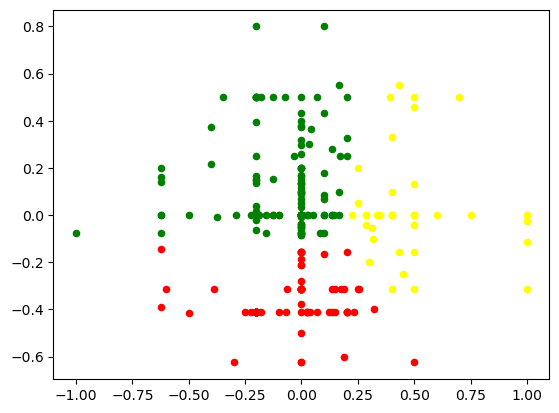

In [14]:
%store -r textblob_sentiment_df
axis = textblob_sentiment_df.iloc[:, -2:].values

# To implement k-means and differentiating three sentiment categories
km = KMeans(n_clusters = 3, init = 'k-means++', random_state = 0)
y_km = km.fit_predict(axis)

# Visualizing through scatter plot
# For positive 
plt.scatter(axis[y_km == 0, 0], axis[y_km == 0, 1], s = 20, c = 'green')

# For negative 
plt.scatter(axis[y_km == 1, 0], axis[y_km == 1, 1], s = 20, c = 'red')

# For neutral 
plt.scatter(axis[y_km == 2, 0], axis[y_km == 2, 1], s = 20, c = 'yellow')

# Sentiment Prediction Using Deep Learning - Convolutional Neural Network

Before performing the sentiment prediction, we have to first train our model by providing train data. For this, I downloaded sample dataset from https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news/kernels where news is categorized as positive, negative and neutral.

In [15]:
# Loading sample dataset
df = pd.read_csv("C:/Users/Dell/Desktop/Final Project/all-data.csv", header = None, encoding='latin-1', names=["Sentiment", "Headlines"])
df['Sentiment'] = df['Sentiment'].replace("negative",0).replace("neutral",1).replace("positive",2)
df

,Sentiment,Headlines
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


Now this data needs cleaning and lemmatization

In [16]:
# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Function to clean and tokenize the text
def cleaning_data(text):
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove punctuation and convert to lowercase
    words = [word.lower() for word in words if word.isalpha()]
    
    # Remove stopwords (common words like 'the', 'is', etc.)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    return words

# Applying to dataframe
df['Splitted'] = df['Headlines'].apply(lambda x: cleaning_data(x))

df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Sentiment,Headlines,Splitted
0,1,"According to Gran , the company has no plans t...","[according, gran, company, plans, move, produc..."
1,1,Technopolis plans to develop in stages an area...,"[technopolis, plans, develop, stages, area, le..."
2,0,The international electronic industry company ...,"[international, electronic, industry, company,..."
3,2,With the new production plant the company woul...,"[new, production, plant, company, would, incre..."
4,2,According to the company 's updated strategy f...,"[according, company, updated, strategy, years,..."
...,...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...,"[london, marketwatch, share, prices, ended, lo..."
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, beer, sales, fell, per, cent, mil..."
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...,"[operating, profit, fell, eur, mn, eur, mn, in..."
4844,0,Net sales of the Paper segment decreased to EU...,"[net, sales, paper, segment, decreased, eur, m..."


The data now needs to be split word by word and divided into training and testing

In [17]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Training words
training = [word for tokens in train_df['Splitted'] for word in tokens]

# Testing words
testing = [word for tokens in test_df['Splitted'] for word in tokens]

We have to use Google word to vector model (pre-trained), downloaded from https://code.google.com/archive/p/word2vec/ to implement tokenizing

In [18]:
# Set the file path of the Word2Vec binary file
file_path = "C:/Users/Dell/Desktop/Final Project/GoogleNews-vectors-negative300.bin"

# Load Word2Vec model
WordToVec = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)

Now we will be using Keras to perform text preprocessing because we are interested in implementing Deep Learning

In [19]:
# Initializing and Fitting the Tokenizer
token = Tokenizer(num_words=len(training), char_level=False)
token.fit_on_texts(train_df['Headlines'].tolist())
training = token.texts_to_sequences(train_df['Headlines'].tolist())
train_index = token.word_index
maximum_len = max([len(x) for x in training])

# Sequencing training data to same length
train_data = pad_sequences(training, maxlen=maximum_len)

In [20]:
testing = token.texts_to_sequences(test_df['Headlines'].tolist())

# Sequencing testing data to same length
test_data = pad_sequences(testing, maxlen=maximum_len)

Now, we are ready to embed the word2vec model

In [21]:
# Create an embedding matrix with random initialization
embedding_matrix = np.random.rand(len(train_index) + 1, 300)

# Iterate through words in the training index and update the embedding matrix if the word is in WordToVec
for word, index in train_index.items():
    if word in WordToVec:
        embedding_matrix[index] = WordToVec[word]

# Define an embedding layer using the embedding matrix
embedding_layer = Embedding(input_dim=len(train_index) + 1, 
                            output_dim=300, 
                            weights=[embedding_matrix],
                            input_length=maximum_len,
                            trainable=False)

Now we can perform the CNN (Convolutional Neural Network) modelling

In [22]:
X_train = train_data
X_test = test_data

# Classes for classification
num_classes = 3

# Converting class labels to categorical labels
y_train = to_categorical(train_df['Sentiment'], num_classes=num_classes)
y_test = to_categorical(test_df['Sentiment'], num_classes=num_classes)

In [23]:
# Sequential Model Initialization
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=len(train_index)+1, 
                    output_dim=300, 
                    weights=[embedding_matrix], 
                    input_length=maximum_len, 
                    trainable=False))

#Convolutional Layer
model.add(Conv1D(filters = 200, kernel_size = 3, padding='valid', activation = 'relu'))

# Global Max Pooling Layer
model.add(GlobalMaxPooling1D())

#Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Model Compilation
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
122/122 [==============================] - 8s 34ms/step - loss: 0.8251 - accuracy: 0.6393
Epoch 2/10
122/122 [==============================] - 4s 32ms/step - loss: 0.5723 - accuracy: 0.7634
Epoch 3/10
122/122 [==============================] - 4s 30ms/step - loss: 0.3991 - accuracy: 0.8431
Epoch 4/10
122/122 [==============================] - 4s 30ms/step - loss: 0.2593 - accuracy: 0.9022
Epoch 5/10
122/122 [==============================] - 4s 29ms/step - loss: 0.1384 - accuracy: 0.9600
Epoch 6/10
122/122 [==============================] - 4s 29ms/step - loss: 0.0856 - accuracy: 0.9791
Epoch 7/10
122/122 [==============================] - 4s 29ms/step - loss: 0.0422 - accuracy: 0.9925
Epoch 8/10
122/122 [==============================] - 4s 30ms/step - loss: 0.0447 - accuracy: 0.9912
Epoch 9/10
122/122 [==============================] - 4s 29ms/step - loss: 0.0273 - accuracy: 0.9959
Epoch 10/10
122/122 [==============================] - 4s 29ms/step - loss: 0.0501 - accura

In [24]:
# Evaluating model
model.evaluate(x=X_test, y=y_test, batch_size=None, verbose=1, sample_weight=None)

31/31 [==============================] - 1s 13ms/step - loss: 0.8094 - accuracy: 0.8072


[0.8093783855438232, 0.807216465473175]

Now, finally we can predict the sentiment of headlines and description

In [25]:
%store -r filtered_df

# Tokenize headlines and descriptions
headline_seq = token.texts_to_sequences(filtered_df['Headlines'].tolist())
description_seq = token.texts_to_sequences(filtered_df['Description'].tolist())

# Sequence padding
headline_data = pad_sequences(headline_seq, maxlen=maximum_len)
description_data = pad_sequences(description_seq, maxlen=maximum_len)

# Predicting sentiment scores for headlines and descriptions
y_pred_headline = model.predict(headline_data)
y_pred_description = model.predict(description_data)

# Function for sentiment analysis
def perform_sentiment_analysis(scores):
    sentiments = []
    for item in scores:
        for i in range(0,3):
            if item[i] == max(item):
                sentiments.append(i)
    return sentiments

# Scores for headlines and descriptions
headline_sentiment = perform_sentiment_analysis(y_pred_headline)
description_sentiment = perform_sentiment_analysis(y_pred_description)

# Combining both
def combine_sentiments(headline_sentiment, description_sentiment):
    mutual_sentiments = []
    for s1, s2 in zip(headline_sentiment, description_sentiment):
        if s1 +s2 > 2:
            mutual_sentiments.append(2)
        elif s1 + s2 == 2:
            mutual_sentiments.append(1)
        elif s1 + s2 < 2:
            mutual_sentiments.append(0)
    return mutual_sentiments

final_sentiment = combine_sentiments(headline_sentiment, description_sentiment)


%store -r filtered_df
filtered_df['Final_sentiment'] = final_sentiment
%store filtered_df

# Saving the final_df DataFrame to a CSV file
filtered_df.to_csv("final_sentiment_data.csv", index=False)

9/9 [==============================] - 0s 12ms/step
Stored 'filtered_df' (DataFrame)


We no get a final dataset with sentiment analysis performed on it such that the values are assigned as below according to the sentiment analysed:


0 - Negative
1 - Neutral
2 - Positive

In [2]:
!pip install wordcloud

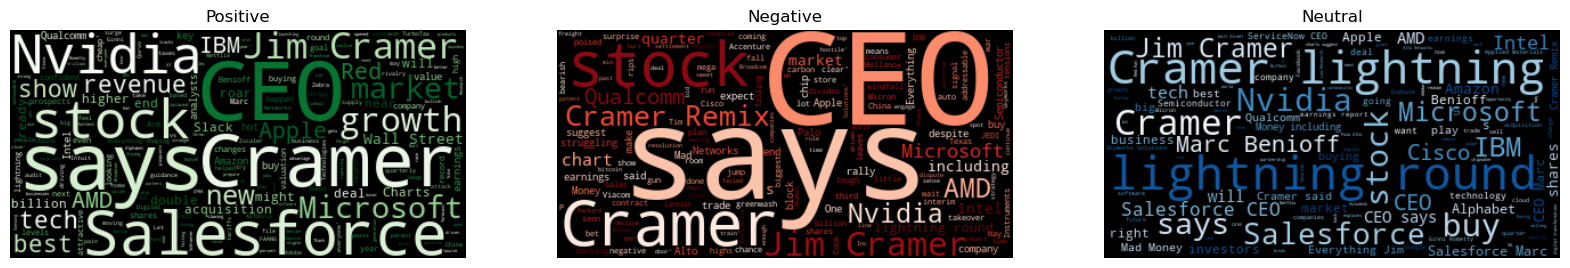

In [5]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the DataFrame from the CSV file
filtered_df = pd.read_csv('final_sentiment_data.csv')

# Get text columns
headlines = filtered_df['Headlines'].tolist()
descriptions = filtered_df['Description'].tolist()
text = headlines + descriptions 

# Get sentiment labels
sentiments = filtered_df['Final_sentiment'].tolist()

# Split text based on sentiment 
pos_text = " ".join([t for t, s in zip(text, sentiments) if s == 2])
neg_text = " ".join([t for t, s in zip(text, sentiments) if s == 0])
neu_text = " ".join([t for t, s in zip(text, sentiments) if s == 1])

# Generate wordclouds 
pos_cloud = WordCloud(colormap='Greens').generate(pos_text)  # Adjust colormap
neg_cloud = WordCloud(colormap='Reds').generate(neg_text)
neu_cloud = WordCloud(colormap='Blues').generate(neu_text)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(pos_cloud, interpolation='bilinear')  # Improve interpolation for smoother image
axes[1].imshow(neg_cloud, interpolation='bilinear') 
axes[2].imshow(neu_cloud, interpolation='bilinear')
axes[0].set_title('Positive')
axes[1].set_title('Negative')
axes[2].set_title('Neutral')

# Remove axes for better visualization
for ax in axes:
    ax.axis('off')

plt.show()
